# Scenario Selection Evaluation

This notebook validates the selected scenarios, plots representative graphs, and computes clustering metrics (e.g., silhouette score)


In [1]:
from pathlib import Path
import json
import os
import glob
import pickle
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, silhouette_samples
import warnings

warnings.filterwarnings('ignore')


def find_repo_root(start=None):
    if start is None:
        start = Path.cwd()
    start = start.resolve()
    for parent in [start] + list(start.parents):
        if (parent / '.git').exists():
            return parent
        if (parent / 'data' / 'sub20' / 'graphs').exists():
            return parent
    raise FileNotFoundError("Could not find repo root (no .git or data/sub20/graphs found)")


ROOT = find_repo_root()

# Prefer repo-root graphs/ if it exists, otherwise fall back to data/sub20/graphs
if (ROOT / 'graphs').exists():
    GRAPHS_DIR = ROOT / 'graphs'
else:
    GRAPHS_DIR = ROOT / 'data' / 'sub20' / 'graphs'

OUTPUT_DIR = ROOT / 'src' / 'kernels' / 'outputs'
OUTPUT_DIR.mkdir(exist_ok=True)

print('ROOT:', ROOT)
print('GRAPHS_DIR:', GRAPHS_DIR)
print('OUTPUT_DIR:', OUTPUT_DIR)



ROOT: /Users/ignaciagothe/Desktop/proyecto graph kernels/graph_scenarios
GRAPHS_DIR: /Users/ignaciagothe/Desktop/proyecto graph kernels/graph_scenarios/data/sub20/graphs
OUTPUT_DIR: /Users/ignaciagothe/Desktop/proyecto graph kernels/graph_scenarios/src/kernels/outputs


In [2]:
# Load selection outputs
K_VALUES = [20, 100]


def load_selection(k):
    path_graphs = OUTPUT_DIR / f"selected_graphs_k{k}.json"
    path_scenarios = OUTPUT_DIR / f"selected_scenarios_k{k}.json"
    if path_graphs.exists():
        data = json.loads(path_graphs.read_text())
        data['_path'] = path_graphs
        data['_format'] = 'selected_graphs'
        return data
    if path_scenarios.exists():
        data = json.loads(path_scenarios.read_text())
        data['_path'] = path_scenarios
        data['_format'] = 'selected_scenarios'
        return data
    raise FileNotFoundError(f"No selection file found for k={k} in {OUTPUT_DIR}")


selections = {k: load_selection(k) for k in K_VALUES}
for k, data in selections.items():
    print(f"k={k} | format={data['_format']} | path={data['_path'].name}")


k=20 | format=selected_graphs | path=selected_graphs_k20.json
k=100 | format=selected_graphs | path=selected_graphs_k100.json


In [3]:
# Build graph file index (for validation)
pattern = None
for data in selections.values():
    if 'pattern' in data:
        pattern = data['pattern']
        break
if pattern is None:
    pattern = 'graph_*.pickle'

all_graph_files = sorted(glob.glob(str(GRAPHS_DIR / pattern)))
all_graph_basenames = [os.path.basename(p) for p in all_graph_files]
name_to_index = {name: idx for idx, name in enumerate(all_graph_basenames)}

print(f"Found {len(all_graph_files)} graphs using pattern '{pattern}'")


Found 49125 graphs using pattern 'graph_*.pickle'


In [4]:
# Parse selection outputs into a common shape and validate file selection

def parse_selection(data, k):
    selected_files = []
    selected_indices = None
    cluster_labels = None
    cluster_sizes = None

    if data['_format'] == 'selected_graphs':
        selected_files = data['selected_pickle_files']
        selected_indices = data.get('selected_indices')
        cluster_labels = np.array(data.get('cluster_labels', []), dtype=int)
        cluster_sizes = data.get('cluster_sizes')
    else:
        selected_files = [s['filename'] for s in data['selected_scenarios']]
        cluster_sizes = [s['cluster_size'] for s in data['selected_scenarios']]
        labels_path = OUTPUT_DIR / f"cluster_assignments_k{k}.npy"
        if labels_path.exists():
            cluster_labels = np.load(labels_path)

    # Validate selected files exist
    missing = [f for f in selected_files if f not in name_to_index]
    if missing:
        print(f"[warn] k={k}: missing files: {missing[:5]}{'...' if len(missing) > 5 else ''}")
    else:
        print(f"[ok] k={k}: all selected files exist")

    # Validate index mapping if provided
    if selected_indices is not None:
        mismatches = []
        for idx, fname in zip(selected_indices, selected_files):
            if idx >= len(all_graph_basenames) or all_graph_basenames[idx] != fname:
                mismatches.append((idx, fname))
        if mismatches:
            print(f"[warn] k={k}: index->filename mismatches: {mismatches[:3]}")
        else:
            print(f"[ok] k={k}: selected_indices match filenames")

    # Validate cluster sizes if labels are present
    label_counts = None
    if cluster_labels is not None and cluster_labels.size > 0:
        label_counts = np.bincount(cluster_labels, minlength=k)
        if cluster_sizes is not None and len(cluster_sizes) == k:
            if not np.all(label_counts == np.array(cluster_sizes)):
                print(f"[warn] k={k}: cluster_sizes do not match label counts")
            else:
                print(f"[ok] k={k}: cluster_sizes match label counts")
        if selected_indices is not None:
            # Medoid label should match its cluster id (order of medoids)
            bad_medoids = []
            for cluster_id, medoid_idx in enumerate(selected_indices):
                if medoid_idx < len(cluster_labels) and cluster_labels[medoid_idx] != cluster_id:
                    bad_medoids.append((cluster_id, medoid_idx, cluster_labels[medoid_idx]))
            if bad_medoids:
                print(f"[warn] k={k}: medoid label mismatches: {bad_medoids[:3]}")
            else:
                print(f"[ok] k={k}: medoid labels consistent")

    return {
        'selected_files': selected_files,
        'selected_indices': selected_indices,
        'cluster_labels': cluster_labels,
        'cluster_sizes': cluster_sizes,
        'label_counts': label_counts,
    }


parsed = {k: parse_selection(data, k) for k, data in selections.items()}


[ok] k=20: all selected files exist
[ok] k=20: selected_indices match filenames
[ok] k=20: cluster_sizes match label counts
[ok] k=20: medoid labels consistent
[ok] k=100: all selected files exist
[ok] k=100: selected_indices match filenames
[ok] k=100: cluster_sizes match label counts
[ok] k=100: medoid labels consistent


In [5]:
# --- WL feature sample for silhouette computation ---
import sys
from scipy import sparse
from tqdm import tqdm

kernels_dir = ROOT / 'src' / 'kernels'
if str(kernels_dir) not in sys.path:
    sys.path.append(str(kernels_dir))

from kernel_baseline import DirectedWLKernelHasher, row_l2_norms, row_normalize, load_nx_dag

# WL params from selection metadata (fallback defaults)
meta = selections[K_VALUES[0]]
wl_iterations = meta.get('wl_iterations', 3)
hash_dim = meta.get('hash_dim', 2**18)
node_label_attr = meta.get('node_label_attr')

sample_size = 5000  # reduce if you hit memory limits
n_graphs = len(all_graph_files)
np.random.seed(42)
sample_idx = np.random.choice(n_graphs, size=min(sample_size, n_graphs), replace=False)
sample_idx = np.sort(sample_idx)

# Load graphs and compute WL features for the sample
graphs_sample = []
for idx in tqdm(sample_idx, desc='Loading graphs for silhouette'):
    G = load_nx_dag(all_graph_files[idx])
    graphs_sample.append(G)

hasher = DirectedWLKernelHasher(h=wl_iterations, hash_dim=hash_dim, node_label_attr=node_label_attr)
X = hasher.fit_transform(graphs_sample)
norms = row_l2_norms(X)
Xn = row_normalize(X, norms)

# Cosine distance matrix for the sample
S = (Xn @ Xn.T).toarray()
S = np.clip(S, -1.0, 1.0)
D = np.sqrt(np.maximum(2.0 - 2.0 * S, 0.0))
np.fill_diagonal(D, 0.0)

print('Sample size:', len(sample_idx), '| D shape:', D.shape)



Loading graphs for silhouette:   0%|          | 0/5000 [00:00<?, ?it/s]

Loading graphs for silhouette:   3%|▎         | 152/5000 [00:00<00:03, 1513.65it/s]

Loading graphs for silhouette:   6%|▋         | 315/5000 [00:00<00:02, 1577.93it/s]

Loading graphs for silhouette:   9%|▉         | 473/5000 [00:00<00:02, 1555.92it/s]

Loading graphs for silhouette:  13%|█▎        | 629/5000 [00:00<00:02, 1461.26it/s]

Loading graphs for silhouette:  17%|█▋        | 860/5000 [00:00<00:02, 1476.23it/s]

Loading graphs for silhouette:  22%|██▏       | 1101/5000 [00:00<00:02, 1749.33it/s]

Loading graphs for silhouette:  26%|██▌       | 1281/5000 [00:00<00:02, 1532.46it/s]

Loading graphs for silhouette:  30%|███       | 1517/5000 [00:00<00:01, 1750.16it/s]

Loading graphs for silhouette:  34%|███▍      | 1701/5000 [00:01<00:02, 1486.38it/s]

Loading graphs for silhouette:  39%|███▉      | 1939/5000 [00:01<00:01, 1707.26it/s]

Loading graphs for silhouette:  43%|████▎     | 2136/5000 [00:01<00:01, 1438.84it/s]

Loading graphs for silhouette:  48%|████▊     | 2384/5000 [00:01<00:01, 1678.21it/s]

Loading graphs for silhouette:  52%|█████▏    | 2614/5000 [00:01<00:01, 1831.88it/s]

Loading graphs for silhouette:  56%|█████▋    | 2814/5000 [00:01<00:01, 1452.62it/s]

Loading graphs for silhouette:  61%|██████    | 3056/5000 [00:01<00:01, 1669.25it/s]

Loading graphs for silhouette:  66%|██████▋   | 3322/5000 [00:02<00:00, 1908.87it/s]

Loading graphs for silhouette:  71%|███████▏  | 3569/5000 [00:02<00:00, 2051.24it/s]

Loading graphs for silhouette:  76%|███████▌  | 3792/5000 [00:02<00:00, 1494.65it/s]

Loading graphs for silhouette:  81%|████████  | 4030/5000 [00:02<00:00, 1684.64it/s]

Loading graphs for silhouette:  85%|████████▍ | 4247/5000 [00:02<00:00, 1796.78it/s]

Loading graphs for silhouette:  90%|████████▉ | 4481/5000 [00:02<00:00, 1932.19it/s]

Loading graphs for silhouette:  94%|█████████▍| 4695/5000 [00:02<00:00, 1339.39it/s]

Loading graphs for silhouette:  99%|█████████▊| 4936/5000 [00:03<00:00, 1555.94it/s]

Loading graphs for silhouette: 100%|██████████| 5000/5000 [00:03<00:00, 1633.17it/s]

WL features (directed):   0%|          | 0/5000 [00:00<?, ?it/s]

WL features (directed):   1%|▏         | 65/5000 [00:00<00:07, 643.53it/s]

WL features (directed):   3%|▎         | 140/5000 [00:00<00:06, 704.32it/s]

WL features (directed):   4%|▍         | 211/5000 [00:00<00:06, 689.59it/s]

WL features (directed):   6%|▌         | 281/5000 [00:00<00:07, 626.42it/s]

WL features (directed):   7%|▋         | 345/5000 [00:00<00:07, 629.26it/s]

WL features (directed):   8%|▊         | 411/5000 [00:00<00:07, 637.38it/s]

WL features (directed):  10%|▉         | 484/5000 [00:00<00:06, 662.43it/s]

WL features (directed):  11%|█         | 553/5000 [00:00<00:06, 667.72it/s]

WL features (directed):  12%|█▏        | 621/5000 [00:00<00:06, 669.43it/s]

WL features (directed):  14%|█▍        | 689/5000 [00:01<00:06, 660.40it/s]

WL features (directed):  15%|█▌        | 756/5000 [00:01<00:06, 641.63it/s]

WL features (directed):  16%|█▋        | 821/5000 [00:01<00:06, 641.55it/s]

WL features (directed):  18%|█▊        | 886/5000 [00:01<00:06, 639.80it/s]

WL features (directed):  19%|█▉        | 956/5000 [00:01<00:06, 657.40it/s]

WL features (directed):  20%|██        | 1022/5000 [00:01<00:06, 642.75it/s]

WL features (directed):  22%|██▏       | 1089/5000 [00:01<00:06, 647.36it/s]

WL features (directed):  23%|██▎       | 1157/5000 [00:01<00:05, 656.36it/s]

WL features (directed):  24%|██▍       | 1223/5000 [00:01<00:05, 635.76it/s]

WL features (directed):  26%|██▌       | 1288/5000 [00:01<00:05, 638.68it/s]

WL features (directed):  27%|██▋       | 1358/5000 [00:02<00:05, 652.92it/s]

WL features (directed):  28%|██▊       | 1424/5000 [00:02<00:05, 649.45it/s]

WL features (directed):  30%|██▉       | 1490/5000 [00:02<00:05, 638.39it/s]

WL features (directed):  31%|███       | 1554/5000 [00:02<00:05, 615.29it/s]

WL features (directed):  32%|███▏      | 1621/5000 [00:02<00:05, 627.63it/s]

WL features (directed):  34%|███▎      | 1687/5000 [00:02<00:05, 635.68it/s]

WL features (directed):  35%|███▌      | 1751/5000 [00:02<00:05, 636.22it/s]

WL features (directed):  36%|███▋      | 1820/5000 [00:02<00:04, 649.60it/s]

WL features (directed):  38%|███▊      | 1886/5000 [00:02<00:04, 645.31it/s]

WL features (directed):  39%|███▉      | 1951/5000 [00:03<00:04, 635.45it/s]

WL features (directed):  40%|████      | 2015/5000 [00:03<00:04, 630.26it/s]

WL features (directed):  42%|████▏     | 2079/5000 [00:03<00:04, 631.92it/s]

WL features (directed):  43%|████▎     | 2143/5000 [00:03<00:04, 625.48it/s]

WL features (directed):  44%|████▍     | 2216/5000 [00:03<00:04, 653.30it/s]

WL features (directed):  46%|████▌     | 2282/5000 [00:03<00:04, 654.72it/s]

WL features (directed):  47%|████▋     | 2348/5000 [00:03<00:04, 643.60it/s]

WL features (directed):  48%|████▊     | 2413/5000 [00:03<00:04, 641.00it/s]

WL features (directed):  50%|████▉     | 2478/5000 [00:03<00:03, 632.97it/s]

WL features (directed):  51%|█████     | 2543/5000 [00:03<00:03, 636.19it/s]

WL features (directed):  52%|█████▏    | 2607/5000 [00:04<00:03, 635.44it/s]

WL features (directed):  53%|█████▎    | 2671/5000 [00:04<00:03, 629.51it/s]

WL features (directed):  55%|█████▍    | 2739/5000 [00:04<00:03, 642.09it/s]

WL features (directed):  56%|█████▌    | 2806/5000 [00:04<00:03, 648.21it/s]

WL features (directed):  57%|█████▋    | 2871/5000 [00:04<00:03, 644.27it/s]

WL features (directed):  59%|█████▊    | 2937/5000 [00:04<00:03, 648.58it/s]

WL features (directed):  60%|██████    | 3002/5000 [00:04<00:03, 639.90it/s]

WL features (directed):  61%|██████▏   | 3069/5000 [00:04<00:02, 647.58it/s]

WL features (directed):  63%|██████▎   | 3145/5000 [00:04<00:02, 679.98it/s]

WL features (directed):  64%|██████▍   | 3214/5000 [00:04<00:02, 653.34it/s]

WL features (directed):  66%|██████▌   | 3291/5000 [00:05<00:02, 683.39it/s]

WL features (directed):  67%|██████▋   | 3360/5000 [00:05<00:02, 677.04it/s]

WL features (directed):  69%|██████▊   | 3428/5000 [00:05<00:02, 669.50it/s]

WL features (directed):  70%|██████▉   | 3496/5000 [00:05<00:02, 669.09it/s]

WL features (directed):  71%|███████▏  | 3563/5000 [00:05<00:02, 665.15it/s]

WL features (directed):  73%|███████▎  | 3630/5000 [00:05<00:02, 654.57it/s]

WL features (directed):  74%|███████▍  | 3698/5000 [00:05<00:01, 658.60it/s]

WL features (directed):  75%|███████▌  | 3764/5000 [00:05<00:01, 652.83it/s]

WL features (directed):  77%|███████▋  | 3830/5000 [00:05<00:01, 645.77it/s]

WL features (directed):  78%|███████▊  | 3895/5000 [00:06<00:01, 646.67it/s]

WL features (directed):  79%|███████▉  | 3960/5000 [00:06<00:01, 646.58it/s]

WL features (directed):  80%|████████  | 4025/5000 [00:06<00:01, 627.49it/s]

WL features (directed):  82%|████████▏ | 4088/5000 [00:06<00:01, 605.01it/s]

WL features (directed):  83%|████████▎ | 4149/5000 [00:06<00:01, 605.76it/s]

WL features (directed):  84%|████████▍ | 4211/5000 [00:06<00:01, 608.93it/s]

WL features (directed):  85%|████████▌ | 4273/5000 [00:06<00:01, 602.80it/s]

WL features (directed):  87%|████████▋ | 4334/5000 [00:06<00:01, 593.05it/s]

WL features (directed):  88%|████████▊ | 4394/5000 [00:06<00:01, 592.04it/s]

WL features (directed):  89%|████████▉ | 4457/5000 [00:06<00:00, 601.74it/s]

WL features (directed):  90%|█████████ | 4520/5000 [00:07<00:00, 607.47it/s]

WL features (directed):  92%|█████████▏| 4583/5000 [00:07<00:00, 610.93it/s]

WL features (directed):  93%|█████████▎| 4649/5000 [00:07<00:00, 623.65it/s]

WL features (directed):  94%|█████████▍| 4714/5000 [00:07<00:00, 631.15it/s]

WL features (directed):  96%|█████████▌| 4783/5000 [00:07<00:00, 646.96it/s]

WL features (directed):  97%|█████████▋| 4848/5000 [00:07<00:00, 633.37it/s]

WL features (directed):  98%|█████████▊| 4916/5000 [00:07<00:00, 646.33it/s]

WL features (directed): 100%|█████████▉| 4986/5000 [00:07<00:00, 661.26it/s]

WL features (directed): 100%|██████████| 5000/5000 [00:07<00:00, 642.11it/s]

Sample size: 5000 | D shape: (5000, 5000)


In [6]:
# --- Silhouette scores (sampled) ---
silhouette_results = {}
for k in K_VALUES:
    labels = parsed[k]['cluster_labels']
    if labels is None or len(labels) == 0:
        print(f'k={k}: no cluster labels available for silhouette')
        continue
    if len(labels) != n_graphs:
        print(f'k={k}: label length {len(labels)} != n_graphs {n_graphs}, skipping')
        continue
    labels_sample = np.array(labels)[sample_idx]
    score = silhouette_score(D, labels_sample, metric='precomputed')
    silhouette_results[k] = score
    print(f'k={k} silhouette (sample={len(sample_idx)}): {score:.4f}')


k=20 silhouette (sample=5000): 0.0024
k=100 silhouette (sample=5000): 0.0191


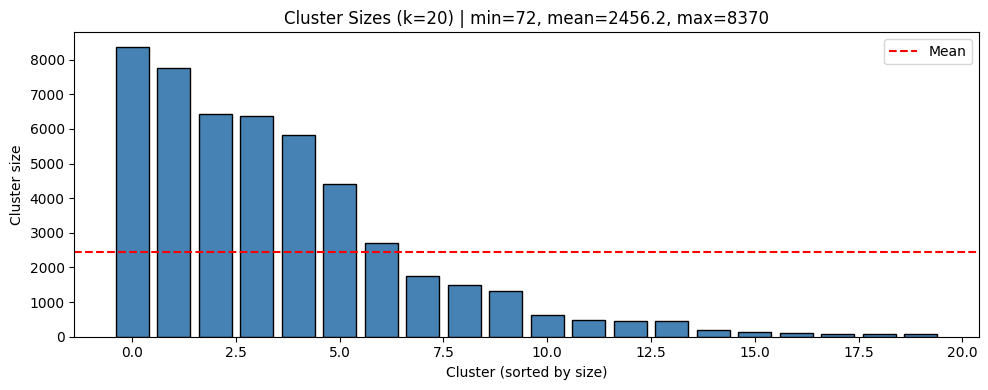

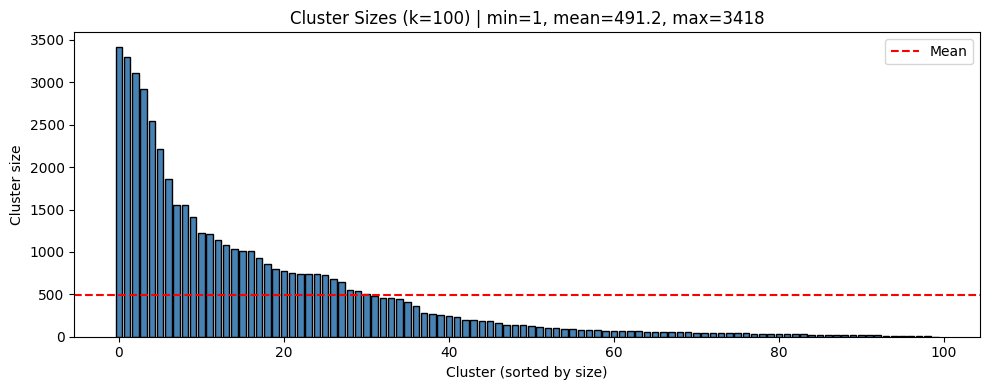

In [7]:
# Cluster size distributions
for k in K_VALUES:
    label_counts = parsed[k]['label_counts']
    if label_counts is None:
        print(f"k={k}: no cluster labels available for size plots")
        continue

    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    ax.bar(range(k), np.sort(label_counts)[::-1], color='steelblue', edgecolor='black')
    ax.set_title(f'Cluster Sizes (k={k}) | min={label_counts.min()}, mean={label_counts.mean():.1f}, max={label_counts.max()}')
    ax.set_xlabel('Cluster (sorted by size)')
    ax.set_ylabel('Cluster size')
    ax.axhline(label_counts.mean(), color='red', linestyle='--', label='Mean')
    ax.legend()
    plt.tight_layout()
    plt.show()


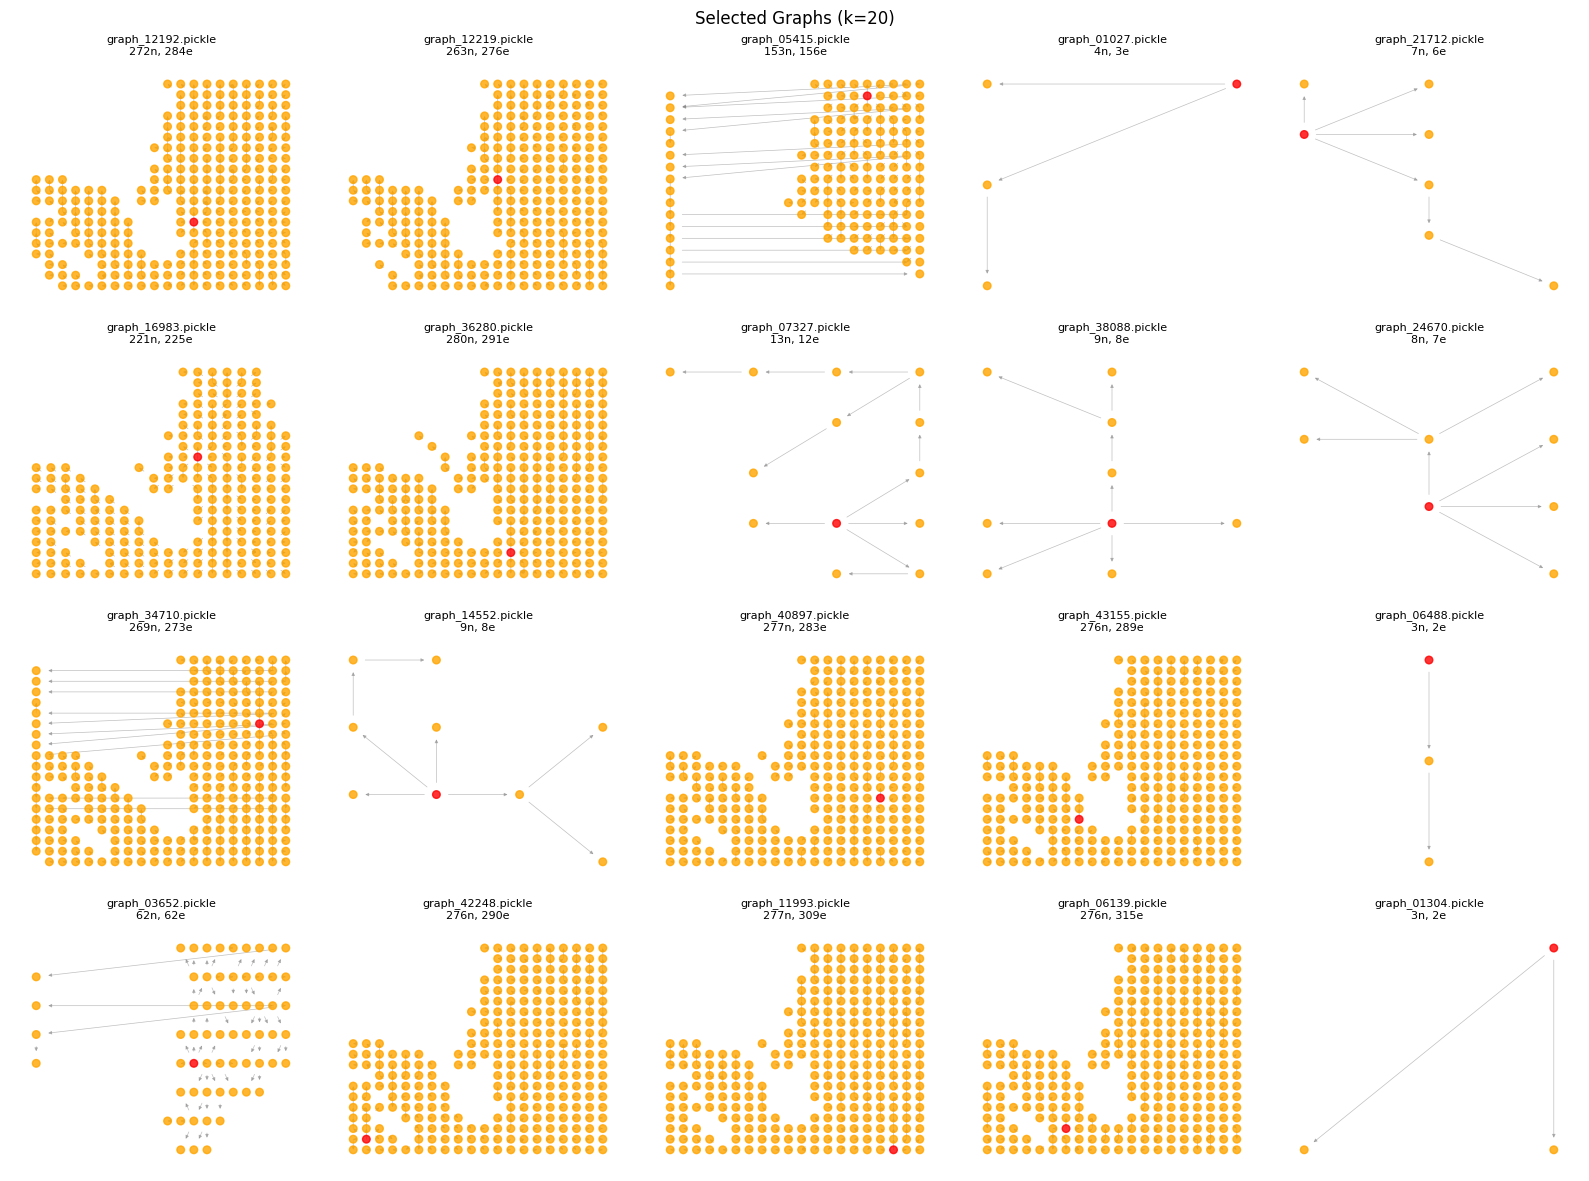

In [8]:
def load_graph_by_name(filename):
    with open(GRAPHS_DIR / filename, 'rb') as f:
        return pickle.load(f)


def graph_stats(G):
    return {
        'nodes': G.number_of_nodes(),
        'edges': G.number_of_edges(),
        'density': nx.density(G) if G.number_of_nodes() > 1 else 0.0,
    }


def grid_positions_20(G):
    nodes = list(G.nodes())
    if not nodes:
        return None
    if not all(isinstance(n, (int, np.integer)) for n in nodes):
        return None
    min_n = int(min(nodes))
    max_n = int(max(nodes))
    if 0 <= min_n and max_n <= 399:
        offset = 0
    elif 1 <= min_n and max_n <= 400:
        offset = 1
    else:
        return None

    pos = {}
    for node in nodes:
        idx = int(node) - offset
        row = idx // 20
        col = idx % 20
        pos[node] = (col, 19 - row)
    return pos


def draw_fire_spread_graph(G, ax, title=''):
    pos = grid_positions_20(G)
    if pos is None:
        pos = nx.spring_layout(G, seed=42)

    if G.is_directed():
        ignition_nodes = [n for n in G.nodes() if G.in_degree(n) == 0]
    else:
        ignition_nodes = []

    node_colors = ['red' if n in ignition_nodes else 'orange' for n in G.nodes()]

    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=30, node_color=node_colors, alpha=0.8)
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color='gray', alpha=0.5,
                           arrows=G.is_directed(), arrowsize=5, width=0.5)

    ax.set_title(title, fontsize=8)
    ax.set_axis_off()


def plot_selected_graphs(k):
    selected_files = parsed[k]['selected_files']
    if not selected_files:
        print(f"k={k}: no selected files to plot")
        return

    graphs = []
    for fname in selected_files:
        G = load_graph_by_name(fname)
        stats = graph_stats(G)
        graphs.append((fname, G, stats))

    cols = 5
    rows = int(np.ceil(len(graphs) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3.2, rows * 3.0))
    axes = np.array(axes).reshape(-1)

    for i, (fname, G, stats) in enumerate(graphs):
        title = f"{fname}\n{stats['nodes']}n, {stats['edges']}e"
        draw_fire_spread_graph(G, axes[i], title)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle(f"Selected Graphs (k={k})", fontsize=12)
    plt.tight_layout()
    plt.show()


plot_selected_graphs(20)

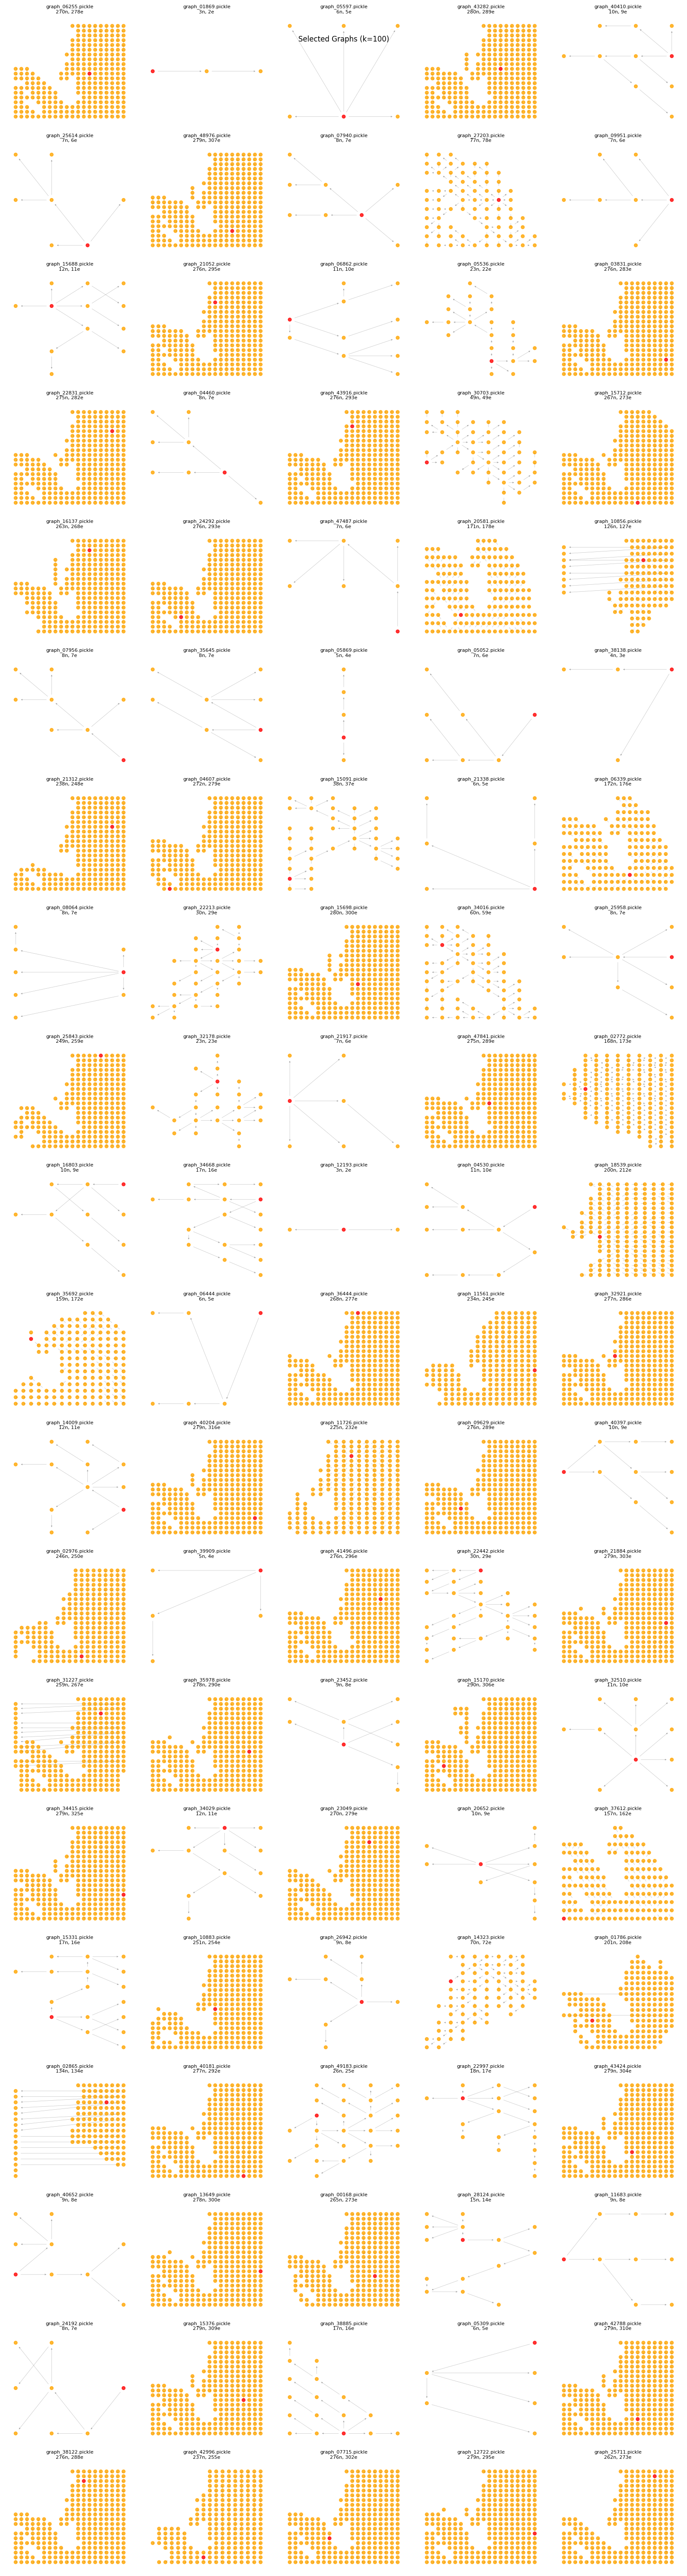

In [9]:
plot_selected_graphs(100)